In [1]:
import pickle
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
from collections import defaultdict

from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_regression
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr, pearsonr, ks_2samp

import sys
sys.path.append('../scripts/')
from utils import *
from config import *
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib as mlp
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns

mlp.rcParams['lines.linewidth'] = 2
mlp.rcParams['axes.grid'] = False
mlp.rcParams['grid.linestyle'] = '--'
mlp.rcParams['xtick.labelsize'] = 12
mlp.rcParams['ytick.labelsize'] = 12
mlp.rcParams['axes.labelsize'] = 14
mlp.rcParams['legend.fontsize'] = 12
#mlp.rcParams['axes.xmargin'] = 0.01
mlp.rcParams['font.size'] = 12
mlp.rcParams['figure.figsize'] = (5,5)

# mlp.rcParams['xtick.direction'] = 'in'
# mlp.rcParams['xtick.major.size'] = 3
# mlp.rcParams['xtick.major.width'] = 0.5
# mlp.rcParams['xtick.minor.size'] = 1.5
# mlp.rcParams['xtick.minor.width'] = 0.5
# mlp.rcParams['xtick.minor.visible'] = True
# mlp.rcParams['xtick.top'] = True

# mlp.rcParams['ytick.direction'] = 'in'
# mlp.rcParams['ytick.major.size'] = 3
# mlp.rcParams['ytick.major.width'] = 0.5
# mlp.rcParams['ytick.minor.size'] = 1.5
# mlp.rcParams['ytick.minor.width'] = 0.5
# mlp.rcParams['ytick.minor.visible'] = True
# mlp.rcParams['ytick.right'] = True

mlp.rcParams['font.family'] = 'serif'
mlp.rcParams['mathtext.fontset'] = 'dejavuserif'

## Load data

In [2]:
with open('../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

## Computing matrix correlation

In [3]:
corr_measure = 'spearman'

In [4]:
df_tmp = df.loc[rows, features+[target]].copy()
df_tmp.drop(columns=target, inplace=True)
df_tmp.reset_index(drop=True, inplace=True)
df_tmp.fillna(-99999, inplace=True)

In [5]:
if corr_measure == 'pearson':
    corr_df = df_tmp.corr(method='pearson')
elif corr_measure == 'spearman':
    corr_df = df_tmp.corr(method='spearman')
elif corr_measure == 'mutual_info':
    combs = list(itertools.combinations_with_replacement(features, 2))
    corr_df = pd.DataFrame(index=features, columns=features)
    for col1, col2 in tqdm(combs):
        mi_tmp = mutual_info_regression(df_tmp[col1].values.reshape(-1, 1), df_tmp[col2].values.reshape(-1, 1))[0]
        corr_df.loc[col1, col2] = mi_tmp
        corr_df.loc[col2, col1] = mi_tmp
    corr_df = corr_df.astype(float)
else:
    raise NotImplementedError('TODO')

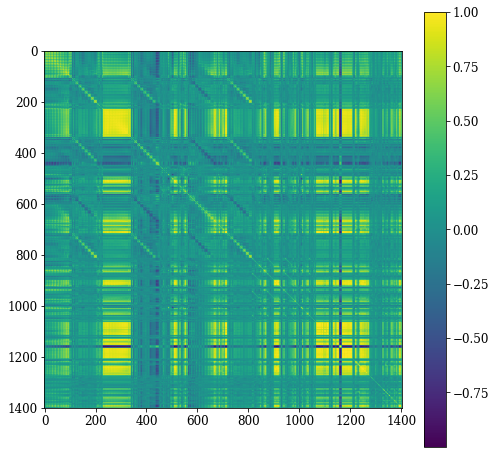

In [6]:
plt.figure(figsize=(8,8))
im = plt.imshow(corr_df/corr_df.stack().max())
cbar = plt.colorbar(im);

## Features clustering

In [7]:
# convert correlation measure to distance metric
if corr_measure in ['pearson', 'spearman']:
    distance_matrix = 1 - corr_df.abs()
elif corr_measure == 'mutual_info':
    raise NotImplementedError('TODO')
else:
    raise NotImplementedError('TODO')

In [8]:
dist_linkage = hierarchy.ward(squareform(distance_matrix))

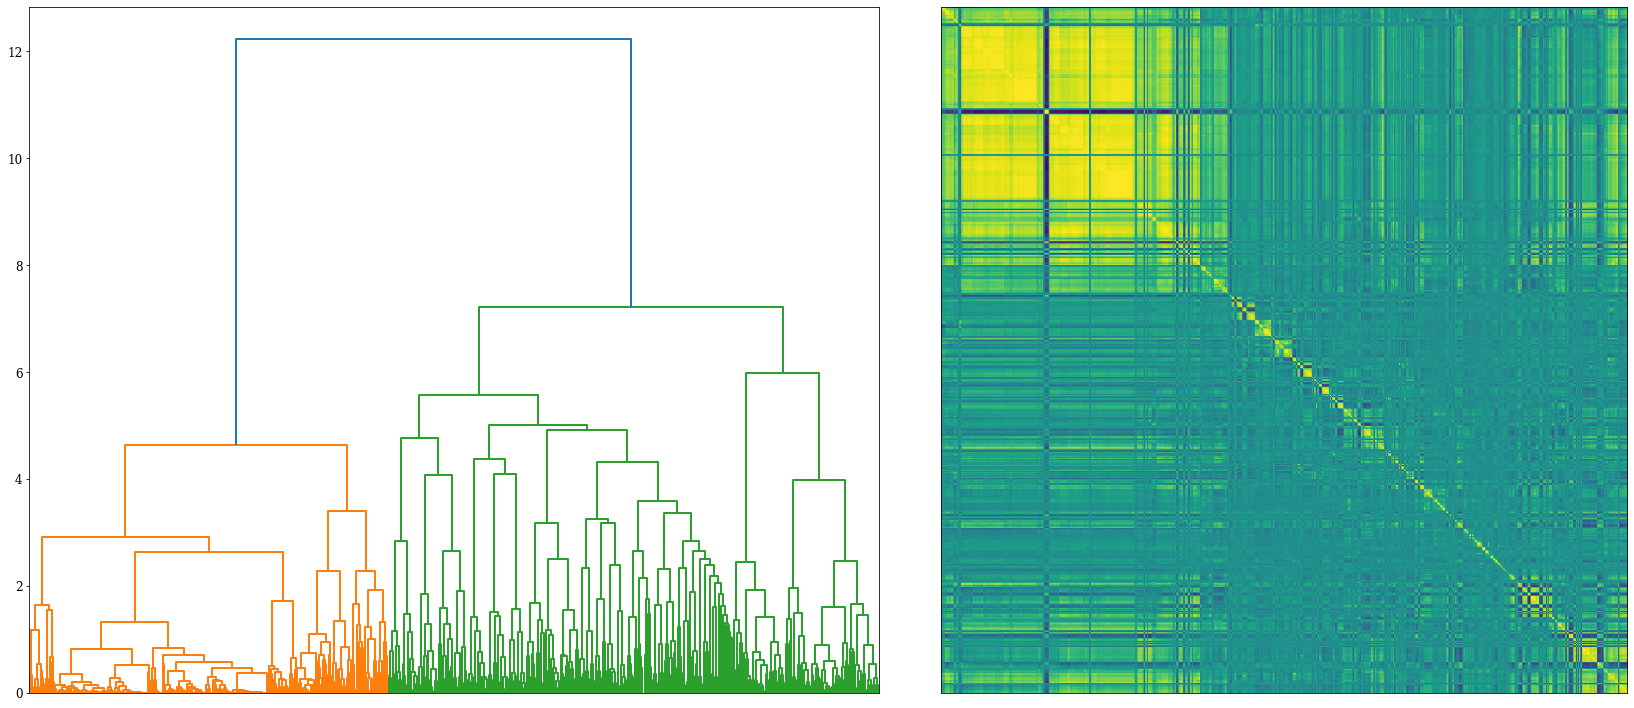

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

dendro = hierarchy.dendrogram(dist_linkage, labels=features, ax=ax1, leaf_rotation=90)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

dendro_idx = np.arange(0, len(dendro["ivl"]))
ax2.imshow(corr_df.values[dendro["leaves"], :][:, dendro["leaves"]])
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
fig.tight_layout()
plt.show()

## Feature selection

In [10]:
comb = df.loc[rows, features + [target]].copy()
comb.reset_index(drop=True, inplace=True)

In [11]:
### compute ks statistics

comb0 = comb[comb[target] == 'Sweet'].copy()
comb1 = comb[comb[target] == 'Bitter'].copy()

ks_df = pd.DataFrame(index=features, columns=['ks'])

for col in tqdm(features):
    x0 = comb0[col].values
    x1 = comb1[col].values
    ks_tmp = ks_2samp(x0, x1)
    ks_df.loc[col, 'ks'] = ks_tmp.statistic

ks_df['ks'] = ks_df['ks'].astype(float)

  0%|          | 0/1402 [00:00<?, ?it/s]

In [12]:
### compute thresholds

clusters_number_dict = {}
clusters_number_dict[np.inf] = 1
clusters_number_tmp = 0
clusters_number_old = 0

for th in np.linspace(-0.1, 10, 1000)[::-1]:
    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")
    clusters_number_tmp = len(np.unique(cluster_ids))
    if clusters_number_tmp > clusters_number_old:
        clusters_number_dict[th] = clusters_number_tmp
        clusters_number_old = clusters_number_tmp

In [13]:
train = comb.copy()
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)

In [15]:
results_df = pd.DataFrame(index=range(len(clusters_number_dict)), columns=['th', 'clusters_number', 'auc_mean', 'auc_std', 'mean_abs_correlation'])

for i, (th, clusters_number) in tqdm(enumerate(clusters_number_dict.items()), total=len(clusters_number_dict)):
    selected_features = []
    if th == np.inf:
        selected_features.append(ks_df.sort_values('ks', ascending=False).head(1).index[0])
        results_tmp = evaluate(params=PARAMS_GB, train=train, features=selected_features, target=target, folds=custom_cv, return_res=True)
        results_df.loc[i, 'th'] = th
        results_df.loc[i, 'clusters_number'] = clusters_number
        results_df.loc[i, 'auc_mean'] = results_tmp.valid_auc.mean()
        results_df.loc[i, 'auc_std'] = results_tmp.valid_auc.std(ddof=0)
        results_df.loc[i, 'mean_abs_correlation'] = corr_df.abs().stack().mean()
    else:
        cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")
        assert(clusters_number == len(np.unique(cluster_ids)))
        
        cluster_id_to_feature = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            cluster_id_to_feature[cluster_id].append(features[idx])
        
        mean_abs_correlation = 0  
        for cluster_id, cluster_features in cluster_id_to_feature.items():
            corr_df_tmp = corr_df.loc[cluster_features, cluster_features].copy()
            mean_abs_correlation += corr_df_tmp.abs().stack().mean() / len(cluster_id_to_feature)
            selected_features.append(ks_df.loc[cluster_id_to_feature[cluster_id], 'ks'].idxmax())
        
        results_tmp = evaluate(params=PARAMS_GB, train=train, features=selected_features, target=target, folds=custom_cv, return_res=True)
        results_df.loc[i, 'th'] = th
        results_df.loc[i, 'clusters_number'] = clusters_number
        results_df.loc[i, 'auc_mean'] = results_tmp.valid_auc.mean()
        results_df.loc[i, 'auc_std'] = results_tmp.valid_auc.std(ddof=0)
        results_df.loc[i, 'mean_abs_correlation'] = mean_abs_correlation

  0%|          | 0/183 [00:00<?, ?it/s]

Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.74497
Fold 2 AUC: 0.77239
Fold 3 AUC: 0.78878
Fold 4 AUC: 0.75461
Fold 5 AUC: 0.75269
Folds AUC: 0.76269+-0.01584
Total AUC: 0.76119
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	cv_agg's train auc: 0.914375 + 0.00276186	cv_agg's valid auc: 0.830016 + 0.0152048
Fold 1 AUC: 0.80526
Fold 2 AUC: 0.84353
Fold 3 AUC: 0.83420
Fold 4 AUC: 0.82094
Fold 5 AUC: 0.84615
Folds AUC: 0.83002+-0.01520
Total AUC: 0.82959
Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.86921
Fold 2 AUC: 0.87883
Fold 3 AUC: 0.86460
Fold 4 AUC: 0.85998
Fold 5 AUC: 0.86805
Folds AUC: 0.86813+-0.00624
Total AUC: 0.86758
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[98]	cv_agg's train auc: 0.996906 + 0.000312283	cv_agg's valid auc: 0.890303 + 0.00460718
Fold 1 AUC: 0.88837
Fold 2 AUC: 0.89575
Fold 3 AUC: 0.89575
Fold 4 

In [16]:
d = {'correlation_matrix': corr_df, 'distance_linkage': dist_linkage, 'Kolmogorov_Smirnov': ks_df, 'thresholds': clusters_number_dict, 'results': results_df}

with open('../data/clustering_results.pickle', 'wb') as handle:
    pickle.dump(d, handle, protocol=pickle.HIGHEST_PROTOCOL)